In [ ]:
import functools
import os
from collections.abc import Callable

import openai
from IPython.display import Image as IPYImage
from IPython.display import display
from PIL import Image

from effectful.handlers.llm import Template
from effectful.handlers.llm.providers import OpenAIAPIProvider
from effectful.handlers.llm.structure import DecodeError, decode
from effectful.handlers.llm.synthesis import ProgramSynthesis
from effectful.ops.semantics import handler

provider = OpenAIAPIProvider(openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY")))

## Interface

The `robotl.ops.llm` module provides a simplified LLM interface that uses algebraic effects to provide modularity. The module interface consists of:

- A decorator `template` which creates a prompt template from a callable. We should think of the prompt template as an LLM-implemented function with behavior specified by a template string. When a templated function is called, an LLM is invoked to produce the specified behavior. The `__call__` method of a template is a handleable operation.
- An operation `decode` which parses LLM output. `decode(t: type, c: str)` converts an LLM response `c` to the type `t`. It can be handled to provide decoding logic for particular types.
- Interpretations for LLM providers `OpenAIIntp` and callable decoding `ProgramSynthesisIntp`. These interpretations can be composed to handle a variety of template behaviors.

## Prompt Templates

This template function writes (bad) poetry on a given theme. While difficult to implement in Python, an LLM can provide a reasonable implementation.

In [ ]:
@Template.define()
def limerick(theme: str) -> str:
    """Write a limerick on the theme of {theme}."""
    raise NotImplementedError

If we call the template with a provider interpretation installed, we get reasonable behavior. The LLM is nondeterministic by default, so calling the template twice with the same arguments gives us different results.

Templates are regular callables, so can be converted to operations with `defop` if we want to override the LLM implementation in some cases.

In [ ]:
with handler(provider):
    print(limerick("fish"))
    print("-" * 40)
    print(limerick("fish"))

A fish with a wish in the sea,  
Dreamed of climbing a tall apple tree.  
Though it lacked any feet,  
It found life quite sweet,  
While swimming as wild as can be.
----------------------------------------
In the sea swam a fish full of flair,  
With scales that would shimmer and glare.  
He'd leap and he'd dive,  
Feeling fully alive,  
Turning flips in the salty sea air.


If we want deterministic behavior, we can cache the template call.

In [ ]:
@functools.cache
@Template.define()
def haiku(theme: str) -> str:
    """Write a haiku on the theme of {theme}."""
    raise NotImplementedError


print()
with handler(provider):
    print(haiku("fish"))
    print("-" * 40)
    print(haiku("fish"))


Gliding through sunbeams,  
Silver scales dance in currents—  
Whispers of the deep.
----------------------------------------
Gliding through sunbeams,  
Silver scales dance in currents—  
Whispers of the deep.


## Converting LLM Results to Python Objects

Type conversion is handled by `decode`. By default, primitive types are converted. `DecodeError` is raised if a response cannot be converted.

In [ ]:
assert type(decode(str, "a string")) is str
assert type(decode(int, "123")) is int
try:
    decode(int, "not an int")
    assert False, "Should have raised"
except DecodeError:
    pass


@Template.define()
def primes(first_digit: int) -> int:
    """Give exactly one prime number with {first_digit} as the first digit. Respond with only the number."""
    raise NotImplementedError


with handler(provider):
    assert type(primes(6)) is int

More complex types can be converted by providing handlers for `decode`. `ProgramSynthesisIntp` provides a `decode` handler that parses Python callables.

In [ ]:
@Template.define()
def count_char(char: str) -> Callable[[str], int]:
    """Write a function which takes a string and counts the occurrances of '{char}'."""
    raise NotImplementedError


try:
    with handler(provider), handler(ProgramSynthesis()):
        count_a = count_char("a")
        assert callable(count_a)
        assert count_a("banana") == 3
        assert count_a("cherry") == 0
except DecodeError as e:
    print("DecodeError:", e.response)
    print("This can happen if the LLM generates code that cannot be parsed.")

## Multimodal Prompts

Prompt templating is largely the same as standard Python templating. However, special case behavior is provided for image template arguments. These are added to the prompt in a provider-API-specific way.

Testing image: _static/img/cat.jpeg


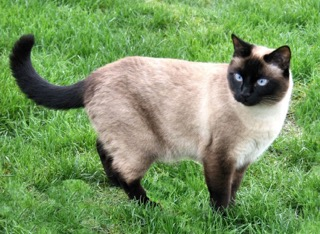

Result: True
Testing image: _static/img/not-cat.jpeg


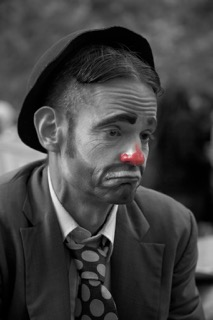

Result: False


In [ ]:
@Template.define()
def is_cat(img: Image.Image) -> bool:
    """Is this a cat? Say True or False and nothing else. {img}"""
    raise NotImplementedError


with handler(provider):
    for img_file in ["_static/img/cat.jpeg", "_static/img/not-cat.jpeg"]:
        print(f"Testing image: {img_file}")
        display(IPYImage(filename=img_file))
        with Image.open(img_file) as img:
            print(f"Result: {is_cat(img)}")